# Computer Vision and OpenCV

This notebook is a part of [AI for Beginners Curriculum](http://aka.ms/ai-beginners).

[OpenCV](https://opencv.org/) is considered to be *de facto* standard for image processing. It contains a lot of useful algorithms, implemented in C++. You can call OpenCV from Python as well.

In this notebooks, we will give you some examples for using OpenCV. For more details, you can visit [Learn OpenCV](https://learnopencv.com/getting-started-with-opencv/) online course. 

First, let's `import cv2`, as well as some other useful libraries:

In [1]:
# you need to issue the following command in the terminal
# sudo apt-get update
# sudo apt-get install xvfb

%pip install opencv-python

import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 22.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


## Loading Images

Images in Python can be conveniently represented by NumPy arrays. For example, grayscale image with size of 320x200 pixels would be stored in 200x320 array, and color image of the same dimension would have shape of 200x320x3 (for 3 color channels). 

Let's start by loading an image:

(242, 531, 3)


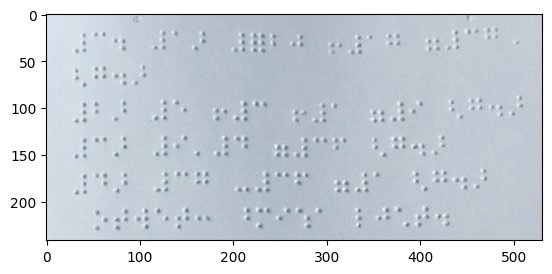

In [2]:
im = cv2.imread('./braille.jpeg')
print(im.shape)
plt.imshow(im)

#opencv는 BGR이라서 색이 달라 보일 수 있음

As you can see, it is an image of braille text. Since we are not interested in the actual color, we can convert it to black-and-white:

(242, 531)


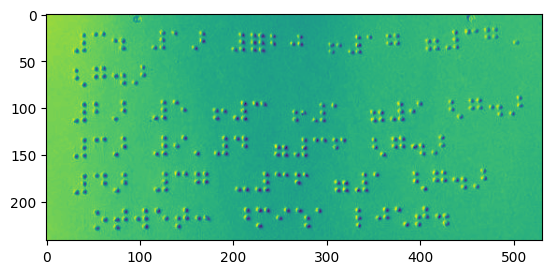

In [4]:
bw_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY) #컬러를 gray로 바꿔라 #초록색처럼 보이는 건 bgr 이라서
print(bw_im.shape) #크기는 바뀌지 않음
plt.imshow(bw_im)

## Braille Image Processing

If we want to apply image classification to recognize the text, we need to cut out individual symbols to make them similar to MNIST images that we have seen before. This can be done using [object detection](../11-ObjectDetection/README.md) technique which we will discuss later, but also we can try to use pure computer vision for that. A good description of how computer vision can be used for character separation can be found [in this blog post](https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) - we will only focus on some computer vision techniques here.

First, let's try to enhance the image a little bit. We can use the idea of **thresholding** (well described [in this OpenCV article](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)): 
스레시홀딩은 바이너리 이미지를 만드는 가장 대표적인 방법

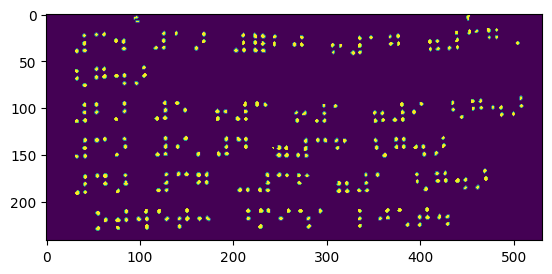

In [5]:
# Blurring: This is done to reduce the noise in the image. You've applied a simple blur with a 3x3 kerne
im = cv2.blur(bw_im,(3,3)) 
# 블러는 함수고 3x3 커널을 한다? cnn의 기본적 개념은 컨볼루션인데 추상화하고 싶다. 
# 전체에 정사각형을 만들고 다양한 숫자를 넣고 곱한다 
# 사람이 물체를 인식할 때 동일하게 선들을 모아 인식함
# 3x3 기준으로 평균을 내면 하나로 통일이 된다.

# Adaptive Thresholding: It converts the grayscale image into a binary image in a more adaptive manner than simple thresholding.
# It's useful for images with varying lighting conditions across different areas
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV, 5, 4)

# Median Blurring: This helps reduce noise further, especially effective for salt-and-pepper noise.
# It replaces each pixel's value with the median value of the intensities in the neighborhood defined by the kernel.
im = cv2.medianBlur(im, 3)
# 특징을 더 강하게 한다?

# Otsu's Thresholding:
# This is a global thresholding technique that automatically determines the best threshold value from the image histogram.
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)

# Gaussian Blurring: Applied to smooth the image, reducing detail and noise. It uses a Gaussian kernel.
im = cv2.GaussianBlur(im, (3,3), 0)
# 블러 한 번 더 

# Another round of Otsu's Thresholding: We are applying Otsu's thresholding again, to refine the binary image after the Gaussian blur.
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
# 한 번 더 

plt.imshow(im)

# 여러 번 반복해서 다양한 종류로 블러와 threshold를 진행한다.
# 방식을 조금씩 바꿔야 함. 같은 걸 여러번 하는 건 의미가 없음
# 배경색이 사라지고 점도 하나의 색으로 통일 되었다.

To work with images, we need to "extract" individual dots, i.e. convert the images to a set of coordinates of individual dots. We can do that using **feature extraction** techniques, such as SIFT, SURF or [ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html):

In [7]:
# Initializes an ORB (Oriented FAST and Rotated BRIEF) detector and descriptor with a maximum number of 5000 features. 
orb = cv2.ORB_create(5000)

# Detects keypoints and computes their descriptors from the image im. 
# A keypoint is a specific location within an image that is used as a reference point for various tasks,
# such as feature matching, object detection, and tracking. 
f,d = orb.detectAndCompute(im,None)

print(f"First 5 points: { [f[i].pt for i in range(5)]}")



First 5 points: [(307.20001220703125, 40.80000305175781), (297.6000061035156, 114.00000762939453), (423.6000061035156, 133.20001220703125), (242.40000915527344, 144.0), (103.68000793457031, 57.60000228881836)]



Let's plot all points to make sure we got things right:

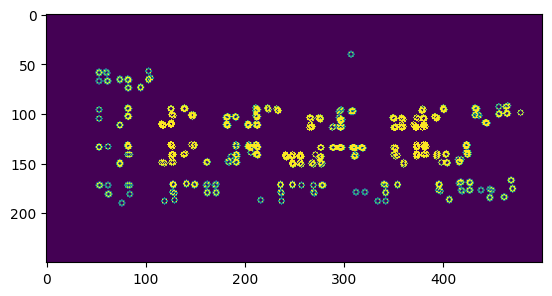

In [8]:
# The function plot_dots is designed to plot dots on a blank image based on coordinates provided by dots.

def plot_dots(dots):
    img = np.zeros((250,500))
    for x in dots:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)

pts = [x.pt for x in f]
plot_dots(pts)  

# 키 포인트를 설정하니 모양이 다르다 

To separate individual characters, we need to know the bounding box of the whole text. To find it out, we can just compute min and max coordinates: 

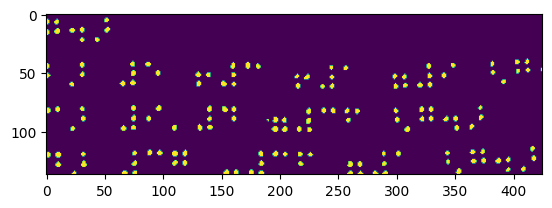

In [9]:
# Assuming 'pts' is a list of tuples/lists with the structure [(x1, y1), (x2, y2), ...]
# Calculate the minimum and maximum x and y coordinates
min_x, min_y, max_x, max_y = [int(f([z[i] for z in pts])) for f in (min,max) for i in (0,1)]

# Adjusting min_y as specified
min_y+=13

# im[min_y:max_y,min_x:max_x] is cropping the image to the specified bounds
plt.imshow(im[min_y:max_y,min_x:max_x])

#여백을 잘라서 점들을 중심으로 했다
#바운딩 박스를 위해 ? 
#오브젝트 디택션과 오브젝트 세그먼트가 있다 
#디택션은 나를 포함하는 모든 박스를 그리면 끝 
# 세그멘테이션은 어디부터 어디까지가 고양이야 !

Also, this text can be partially rotated, and to make it perfectly aligned we need to do so-called **perspective transformation**. We will take a rectangle defined by points $(x_{min},y_{min}), (x_{min},y_{max}), (x_{max},y_{min}), (x_{max},y_{max})$ and align it with new image with proportional dimensions:

The code aims to perform a perspective transformation using OpenCV's findHomography and warpPerspective functions. We define source points src_pts (with a small offset added to the minimum and maximum x, y coordinates) and destination points dst_pts to map the specified quadrilateral region in the source image to a rectangular output image trim.

A quadrilateral is defined as a two-dimensional shape with four sides, four vertices, and four angles.

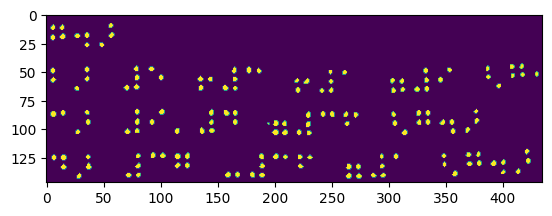

In [10]:
# Offset to be applied around the bounding box
off = 5

# Define source points with the offset applied
src_pts = np.array([(min_x-off,min_y-off),(min_x-off,max_y+off),
                    (max_x+off,min_y-off),(max_x+off,max_y+off)])

# Width of the destination image
w = int(max_x-min_x+off*2)

# Height of the destination image
h = int(max_y-min_y+off*2)

# Define destination points for the rectangular image
dst_pts = np.array([(0,0),(0,h),(w,0),(w,h)])

# Compute the homography matrix (https://towardsdatascience.com/understanding-homography-a-k-a-perspective-transformation-cacaed5ca17)
ho,m = cv2.findHomography(src_pts,dst_pts)

# Perform the perspective warp transformation
trim = cv2.warpPerspective(im,ho,(w,h))
plt.imshow(trim)

After we get this well-aligned image, it should be relatively easy to slice it into pieces:

slice function is designed to slice an image into smaller segments based on a specified character height (char_h) and width (char_w), skipping over any segments that are completely empty (i.e., their maximum pixel value is 0). This can be useful, for example, when working with images of text where each segment represents a character or symbol.

display_images, takes a list of images and the number of columns (cols) to arrange the images in a grid format. Each image slice is displayed in its own subplot, with the axis turned off for a cleaner look. 

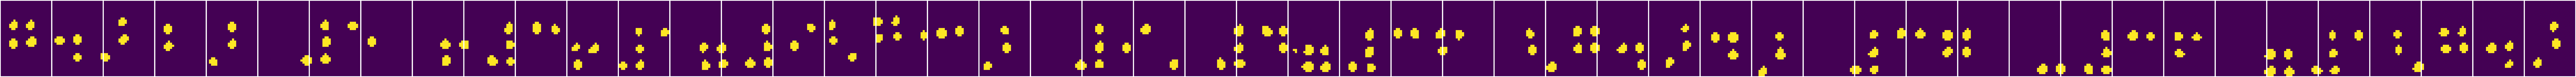

In [11]:
char_h = 36
char_w = 24
def slice(img):
    dy,dx = img.shape
    y = 0
    while y+char_h<dy:
        x=0
        while x+char_w<dx:
            # Skip empty lines
            if np.max(img[y:y+char_h,x:x+char_w])>0:
                yield img[y:y+char_h,x:x+char_w]
            x+=char_w
        y+=char_h

sliced = list(slice(trim))
display_images(sliced)

#잘라서 하나하나 나눔
#문자화한 거
# 하나하나로 인식을 하는 거 알파벳 중에 무었으로 바뀌는지

You have seen that quite a lot of tasks can be done using pure image processing, without any artificial intelligence. If we can use computer vision techniques to make the work of a neural network simpler - we should definitely do it, because it will allow us to solve problems with smaller number of training data.

## Motion Detection using Frame Difference

Detecting motion on video stream is a very frequent task. For example, it allows us to get alerts when something happens on a surveillance camera. If we want to understand what's happening on the camera, we can then use a neural network - but it is much cheaper to use neural network when we know that something is going on.

The main idea of motion detection is simple. If the camera is fixed, then frames from the camera should be pretty similar to each other. Since frames are represented as arrays, just by subtracting those arrays for two subsequent frames we will get the pixel difference, which should be low for static frames, and become higher once there is substantial motion in the image.

We will start by learning how to open a video and convert it into a sequence of frames:  

Total frames: 876


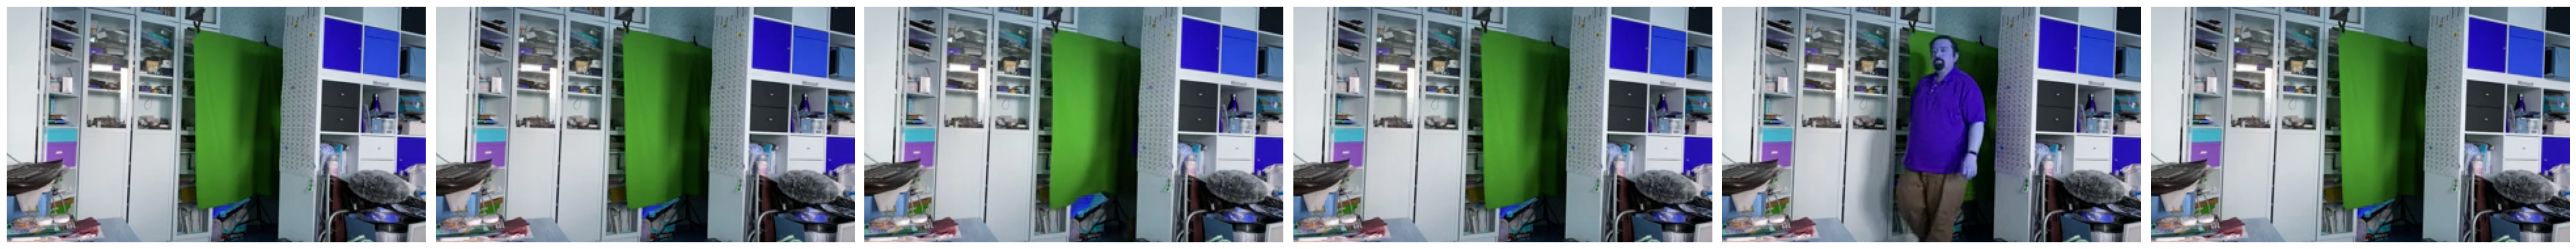

In [13]:
# The code reads a video file named motionvideo.mp4, stores each frame in the list frames, and then aims to display every 150th frame using a display_images function.
# This approach is effective for analyzing or processing specific frames within a video.

vid = cv2.VideoCapture('./motionvideo.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::150])

# 가장 자연스러운 방법은 각각의 프레임과 프레임 사이의 픽셀이 어떻게 변화했는지를 보는 것
# 픽셀의 움직임을 찾는 것, 예를 들어, 눈을 인식하고 눈 픽셀의 변화된 위치를 찾아가는 것

Since color is not so important for motion detection, we will convert all frames to grayscale. Then, we will compute the frame differences, and plot their norms to visually see the amount of activity going on: 

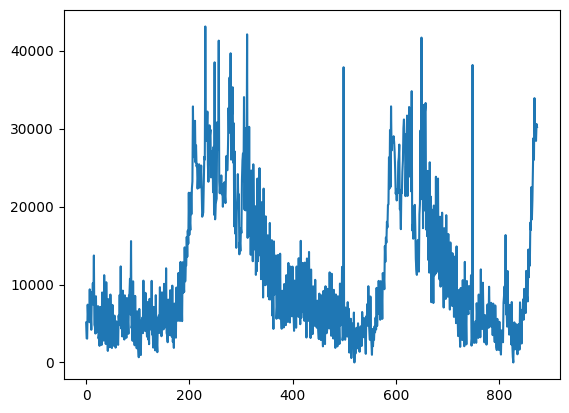

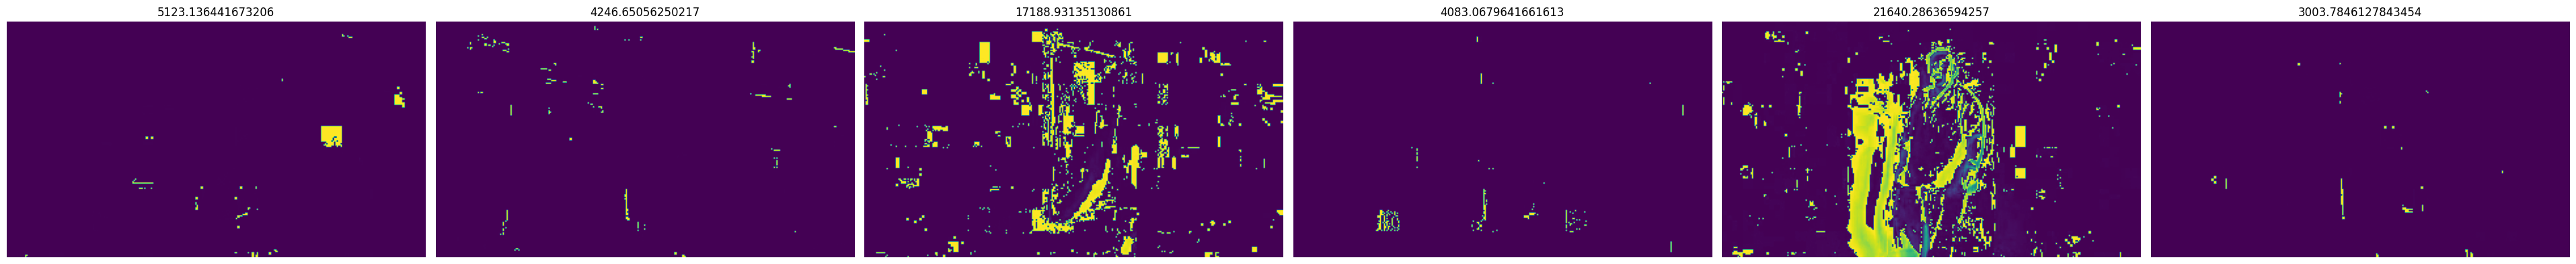

In [14]:
bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
# 색 바꾸는 건데 이번에는 모든 프레임을 바꾸는 것


# Calculate the differences and their amplitudes
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])

# Plotting the difference amplitudes
plt.plot(diff_amps)

# Now display every 150th diff image with amplitude as title
display_images(diffs[::150],titles=diff_amps[::150])

#이거는 진폭 수가 ..
#중간 중ㅇ간 튀는 애들이 이상하다

Suppose we want to create a report that shows what happened in front of the camera by showing the suitable image each time something happens. To do it, we probably want to find out the start and end frame of an "event", and display the middle frame. To remove some noise, we will also smooth out the curve above with moving average function: 

The moving_average function calculates the moving average of a given array x over a window of w elements. This is a common technique in signal processing and time series analysis to smooth out short-term fluctuations and highlight longer-term trends or cycles.

The code plots the moving average of the frame-to-frame difference amplitudes (diff_amps) calculated from video frames, smoothing over 10 elements. Additionally, it draws a horizontal line (plt.axhline) at a specified threshold value, which can be useful for identifying when the moving average of difference amplitudes exceeds a certain level, potentially indicating significant motion or change in the video.

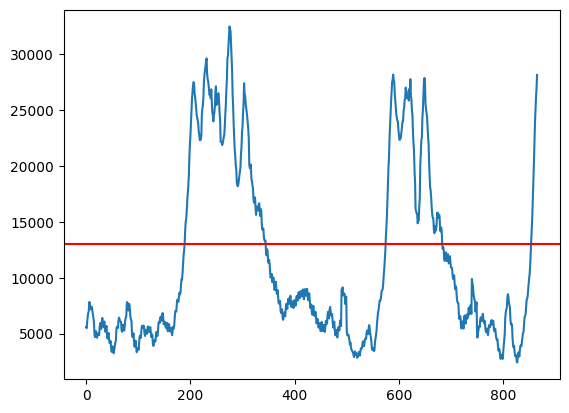

In [17]:
# 이동 평균이란 추세를 보는 것. 
# 1,2,3 평균 내기 2,3,4 평균 내기 3,4,5 평균 내기 (윈도우가 3개짜리) 이런 식으로 내는 것
# 이러면 그래프가 부드러워진다 
# 전체적인 그림을 보는 것 
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Threshold for detecting significant motion/change
threshold = 13000

# Moving average of the difference amplitudes with a window size of 10 then plotting
plt.plot(moving_average(diff_amps,10))
plt.axhline(y=threshold, color='r', linestyle='-')

Now we can find out frames that have the amount of changes above the threshold by using `np.where`, and extract a sequence of consecutive frames that is longer than 30 frames: 

The subsequence function is designed to find and return the first subsequence within a given sequence (seq) where consecutive elements are increasing by 1, and the length of this subsequence is greater than a specified minimum length (min_length). If such a subsequence is found, it returns this subsequence; otherwise, it implicitly returns None.

In [16]:
active_frames = np.where(diff_amps>threshold)[0] # where 가 무ㅓ지 

def subsequence(seq,min_length=30):
    ss = []
    for i,x in enumerate(seq[:-1]):
        ss.append(x)
        if x+1 != seq[i+1]:
            if len(ss)>min_length:
                return ss
            ss.clear()

sub = subsequence(active_frames)
print(sub)

# 프레임의 모든 변화를 보여주는 것은 의미가 없음
# 빛처럼 엄청 빠른 것을 잡을 수 있는 고속 프레임이라면 변수가 많을테지만 ... 
# 그것은 무시하고 .. 
# 큰 변화가 있는 프레임들만 출력

[195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322]


And finally we can display the image:

To display the frame at the midpoint of your identified subsequence (sub), assuming sub contains the indices of the frames in the subsequence.

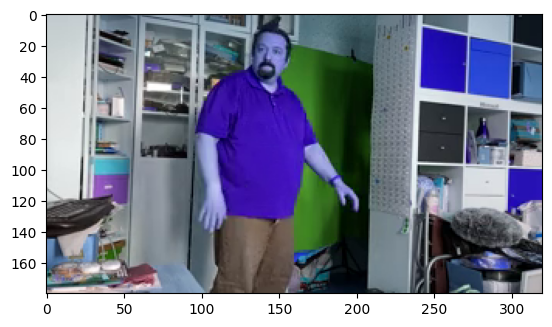

In [18]:
plt.imshow(frames[(sub[0]+sub[-1])//2])

#가장 변화가 많았던 것들

You may notice that color scheme on this image does not look right! This is because OpenCV for historical reasons loads images in BGR color space, while matplotlib uses more traditional RGB color order. Most of the time, it makes sense to convert images to RGB immediately after loading them. 

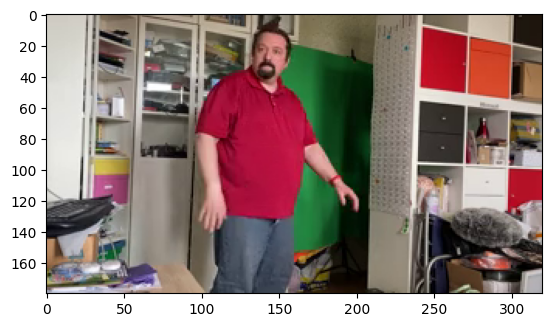

In [19]:
plt.imshow(cv2.cvtColor(frames[(sub[0]+sub[-1])//2],cv2.COLOR_BGR2RGB))

# 색 다시 바뀌는 방법 !! cvtcolor 함수 사용
# 이게 원래 ..

## Extract Motion using Optical Flow

While just comparing two consecutive frames allows us to see the amount of changes, it does not give any information on what is actually moving and where. To get that information, there is a technique called **[optical flow](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html)**:

* **Dense Optical Flow** computes the vector field that shows for each pixel where is it moving
* **Sparse Optical Flow** is based on taking some distinctive features in the image (eg. edges), and building their trajectory from frame to frame.

Read more on optical flow (https://learnopencv.com/optical-flow-in-opencv/).

Let's compute dense optical flow between our frames:

The cv2.calcOpticalFlowFarneback function computes the optical flow between two images using Gunnar Farneback's algorithm. This optical flow method estimates the motion between two images (in this case, consecutive frames in bwframes, which are grayscale versions of the original frames) by analyzing the intensity patterns and how they move between the two frames.

The output of this function for each pair of frames is a 2-channel numpy array. The first channel contains the horizontal displacement (dx) of each pixel, and the second channel contains the vertical displacement (dy). The shape of the output array is the same as the input images' shape but with two channels for the displacements.

In [20]:
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0) 
         for f1,f2 in zip(bwframes[:-1],bwframes[1:])]

# Print the shape of the first optical flow result
flows[0].shape

# 모션 플로우는 벡터로 보여준다
# 실시간이나 추적에는 의미가 있다
# 그러나 두 사람이 있고 둘이 같이 움직이면 누구를 잡을지는 ...
# 더 큰 움직임이 있는 애를 찾아가겠지?
# 두 채널이 있다..?

(180, 320, 2)

As you can see, for each frame the flow has the dimension of the frame, and 2 channels, corresponding to x and y components of optical flow vector.

Displaying optical flow in 2D is a bit challenging, but we can use one clever idea. If we convert optical flow to polar coordinates, then we will get two components for each pixel: *direction* and *intensity*. We can represent intensity by the pixel intensity, and direction by different colors. We will create an image in [HSV (Hue-Saturation-Value) color space](https://en.wikipedia.org/wiki/HSV_color_space), where hue will be defined by direction, value - by intensity, and saturation will be 255. 

The flow_to_hsv function you've defined converts optical flow data (flow) to an HSV (Hue, Saturation, Value) image for visualization purposes. The hue represents the direction of motion, saturation is set to the maximum for visualization clarity, and value (brightness) represents the magnitude of motion. This is a common approach to visualize optical flow because it effectively communicates both the direction and magnitude of motion in a visually intuitive manner.

After converting the optical flows to HSV and then to BGR for display (since matplotlib and most image viewers expect images in RGB or BGR), you're interested in displaying a subset of these images—specifically, those within a range identified by start and stop, and then sampling every 25th frame for display to avoid overcrowding your output.

Given that the display_images function is designed to display a list of images in a grid format using matplotlib and assuming it's already defined in your environment.

HSV 색 공간 또는 HSV 모델은 색을 표현하는 하나의 방법이자, 그 방법에 따라 색을 배치하는 방식이다. 색상(Hue), 채도(Saturation), 명도(Value)의 좌표를 써서 특정한 색을 지정

색상값 H는 가시광선 스펙트럼을 고리모양으로 배치한 색상환에서 가장 파장이 긴 빨강을 0°로 하였을 때 상대적인 배치 각도를 의미한다. 때문에 H 값은 0°~360°의 범위를 갖고 360°와 0°는 같은 색상 빨강을 가리킨다.

채도값 S는 특정한 색상의 가장 진한 상태를 100%로 하였을 때 진함의 정도를 나타낸다. 채도값 0%는 같은 명도의 무채색을 나타낸다.

명도값 V는 흰색, 빨간색 등을 100%, 검은색을 0%로 하였을 때 밝은 정도를 나타낸다.

195 322


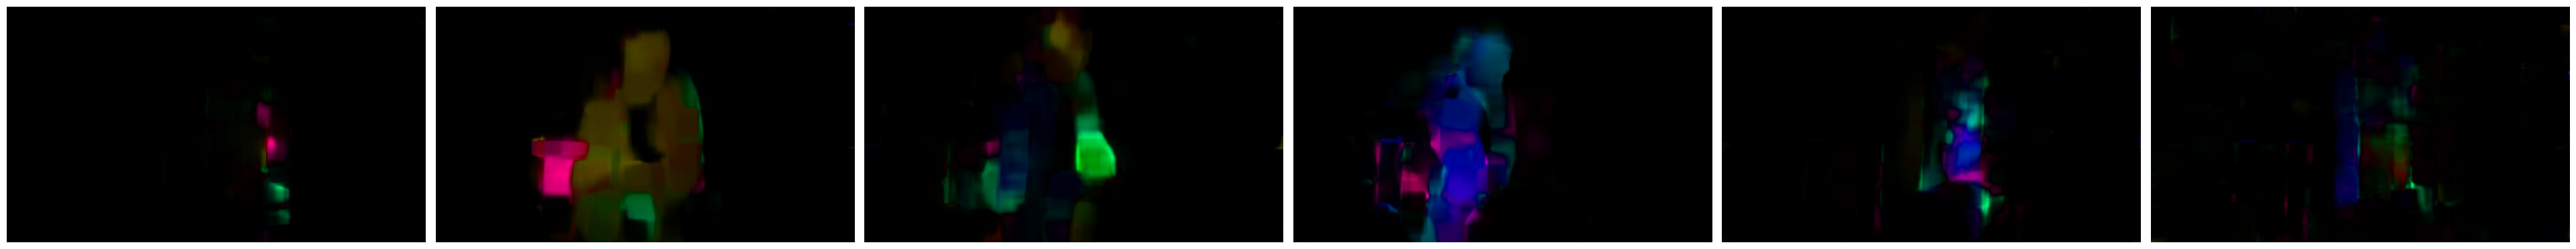

In [21]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

start = sub[0]
stop = sub[-1]
print(start,stop)

frms = [flow_to_hsv(x) for x in flows[start:stop]]
display_images(frms[::25])

# 색상 관련이 있따
# 150마다 찍은 6프레임을 변하는 것들을 색으로 보여준다
# red는 왼쪽 블루는 오른쪽 움직임을 보여준다? 

So, in those frames greenish color corresponds to moving to the left, while blue - moving to the right.

Optical flow can be a great tool to draw conclusions about general direction of movement. For example, if you see that all pixels in a frame are moving in more or less one direction - you can conclude that there is camera movement, and try to compensate for that.